## 三维向前变形算法

In [1]:
import math
import numpy as np
import cv2
from scipy.interpolate import griddata
ORI_DATA_MASS_MAX_DIAMETER = 1200
MAX_POINT = 16
LARGE_THRESHOLD_R = 20
DATA_RESIZE = 0.5
def _interactive_image_warp_multi_point_3D(image, r_list, c_list, m_list, st_list):
    '''
    同时计算多个位移向量的前向变形映射
    '''
    for r, c, m, st in zip(r_list, c_list, m_list, st_list):
        img_z, ori_img_y = np.mgrid[0:image.shape[0], 0:image.shape[1]].astype(np.float32)
        img_y, img_x = np.mgrid[0:image.shape[1], 0:image.shape[2]].astype(np.float32)
        m = np.array(m, np.float32)
        p_in_ring = []
#         print('c, m, r, st:', c, m, r, st)
        c_z = c[0]
        c_y = c[1]
        c_x = c[2]
        for i in range(max(c_z - r, 0), min(c_z + r, image.shape[0])):
            for j in range(max(c_y - r, 0), min(c_y + r, image.shape[1])):
                for k in range(max(c_x - r, 0), min(c_x + r, image.shape[2])):
                    if np.sqrt((i - c_z) ** 2 + (j - c_y) ** 2 + (k - c_x) ** 2) <= r:
                        p_in_ring.append([i, j, k])
#         print('len(p_in_ring)', len(p_in_ring))
        p_in_ring = np.array(p_in_ring, dtype=np.float32)
        m = m[np.newaxis, ...]
        c = np.array([c], np.float32)
        s1 = (r ** 2 - np.sum((p_in_ring - c) ** 2, axis=-1))
        s1 = s1[..., np.newaxis]
        s2 = np.sum((m - c) ** 2, axis=-1)
        u = p_in_ring - ((s1 / (s1 + s2 * (100/st))) ** 2) * (m - c)
        for p_zyx, u_zyx in zip(p_in_ring, u):
#             print(int(p_zyx[0]), int(p_zyx[1]), u_zyx[0])
            img_z[int(p_zyx[0]), int(p_zyx[1])] = u_zyx[0]
            img_y[int(p_zyx[1]), int(p_zyx[2])] = u_zyx[1]
            img_x[int(p_zyx[1]), int(p_zyx[2])] = u_zyx[2]
        
        for x in range(0, image.shape[2], 3):
            if x == image.shape[2] - 2:
                image[:,:,x:x+1] = cv2.remap(image[:,:,x], ori_img_y, img_z, cv2.INTER_CUBIC)[..., np.newaxis]
                image[:,:,x+1:x+2] = cv2.remap(image[:,:,x+1], ori_img_y, img_z, cv2.INTER_CUBIC)[..., np.newaxis]
            elif x == image.shape[2] - 1:
                image[:,:,x::x+1] = cv2.remap(image[:,:,x], ori_img_y, img_z, cv2.INTER_CUBIC)[..., np.newaxis]
            else:
                image[:,:,x:x+3] = cv2.remap(image[:,:,x:x+3], ori_img_y, img_z, cv2.INTER_CUBIC) # zyx
        
        image = image.transpose([1, 2, 0])# yxz
        # 再进行y、x轴的remap
        for z in range(0, image.shape[2], 3):
            if z == image.shape[2] - 2:
                image[:,:,z:z+1] = cv2.remap(image[:,:,z], img_x, img_y, cv2.INTER_CUBIC)[..., np.newaxis]
                image[:,:,z+1:z+2] = cv2.remap(image[:,:,z+1], img_x, img_y, cv2.INTER_CUBIC)[..., np.newaxis]
            elif z == image.shape[2] - 1:
                image[:,:,z:z+1] = cv2.remap(image[:,:,z], img_x, img_y, cv2.INTER_CUBIC)[..., np.newaxis]
            else:
                image[:,:,z:z+3] = cv2.remap(image[:,:,z:z+3], img_x, img_y, cv2.INTER_CUBIC) # INTER_NEAREST
            
        image = image.transpose([2, 0, 1])# zyx
    return image

def _get_line_point_3D(p1, p2, d, out = False):
    '''
    获取某个方向上的点
    p1: (z, y, x)
    p2: (z, y, x)
    d: 获取的点到p1(out == False)或p2(out == True)的距离的距离
    out: 指定获取的点在p1和p2之间(False), 在p1->p2方向上且越过p2(True)
    '''
    dz = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    dx = p2[2] - p1[2]
    
    pd = math.sqrt(dz ** 2 + dy ** 2 + dx ** 2)
    cz = int(dz * d / pd)
    cy = int(dy * d / pd)
    cx = int(dx * d / pd)
    
    if out:
        p = np.array([p2[0] + cz, p2[1] + cy, p2[2] + cx])
    else:
        p = np.array([p1[0] + cz, p1[1] + cy, p1[2] + cx])
    return p

def forward_transform_multi_point_3D(image, center, r, point_num = 26, st = 20):
    '''
    多点向前变形算法
    image: numpy.array, type: uint8, shape:(z, y, x), range: 0~255
    point_num: int, 指定选择多少个点（在边界上均匀选择）, 只能为1或6或26
    st: int, 参考美图秀秀液化瘦脸功能的硬度参数（根据自己的图像进行适当调整）
    '''
    assert(point_num in [1, 6, 26])
    if point_num == 1:
        # 从26个点中随机选一个
        v_z, v_y, v_x = np.mgrid[0:3, 0:3, 0:3].astype(np.float32) - 1.0
        v_z = v_z[..., np.newaxis]
        v_y = v_y[..., np.newaxis]
        v_x = v_x[..., np.newaxis]
        v = np.concatenate([v_z, v_y, v_x], axis = -1)
        v = v.reshape([-1, 3])
        v = np.concatenate([v[:13, :], v[14:, :]], axis = 0)
        assert(len(v) == 26)
        v_idx_list = [i for i in range(26)]
        v_idx = np.random.choice(v_idx_list)
        v = v[v_idx : v_idx + 1, :]
#         print(v)
    elif point_num == 6:
        v = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]], np.float32)
    elif point_num == 26:
        v_z, v_y, v_x = np.mgrid[0:3, 0:3, 0:3].astype(np.float32) - 1.0
#         print(v_z.shape)
        v_z = v_z[..., np.newaxis]
        v_y = v_y[..., np.newaxis]
        v_x = v_x[..., np.newaxis]
        v = np.concatenate([v_z, v_y, v_x], axis = -1)
        v = v.reshape([-1, 3])
#         print(v)
        v = np.concatenate([v[:13, :], v[14:, :]], axis = 0)
#         print(len(v))
        assert(len(v) == 26)
    
    v_len = np.sqrt(np.sum(v ** 2, axis=-1)[:, np.newaxis])
    v = v / v_len
#     print('v', v)
    r = int(r)
#     print('center', center)
    center_broadcast = np.array(center)[np.newaxis, ...]
    v = v + center_broadcast
    point_list = [_get_line_point_3D(center, point, r - 1, out=True) for point in v]
    point_list = np.array(point_list,dtype=np.int32) #+ center_broadcast
#     print('point_list', point_list)
    if r < LARGE_THRESHOLD_R:
        large = True
    else:
        large = np.random.choice([True, False])
    if large:
        p_list = []
        d = np.random.randint(r // 3, r)
        for point in point_list:
#             print('large')
            point_out = _get_line_point_3D(center, point, d, out=True)
#             print(point_out)
            point_out[0] = min(image.shape[0], point_out[0])
            point_out[1] = min(image.shape[1], point_out[1])
            point_out[2] = min(image.shape[2], point_out[2])
            p_list.append(point_out)
    else:
        p_list = []
        d = np.random.randint(r // 3, 2 * r // 3)
        for point in point_list:
#             print('small')
            point_in = _get_line_point_3D(point, center, d, out=False)
#             print(point_in)
            point_in[0] = min(image.shape[0], point_in[0])
            point_in[1] = min(image.shape[1], point_in[1])
            point_in[2] = min(image.shape[2], point_in[2])
            p_list.append(point_in)
    r_list = [r for _ in range(point_num)]
    st_list = [st for _ in range(point_num)]
    image = _interactive_image_warp_multi_point_3D(image, r_list, point_list, p_list, st_list)
#     mask = _interactive_image_warp_multi_point_3D(mask, r_list, point_list, p_list, st_list)
#     mask[mask > 127] = 255
#     mask[mask <= 127] = 0
    return image#, mask

seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
coordX                                                   90.9317
coordY                                                   149.027
coordZ                                                  -426.545
diameter_mm                                              18.2086
Name: 5, dtype: object
1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405
/mnt/data/datasets/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
img_array (321, 512, 512)
r 16
y, x 251 379


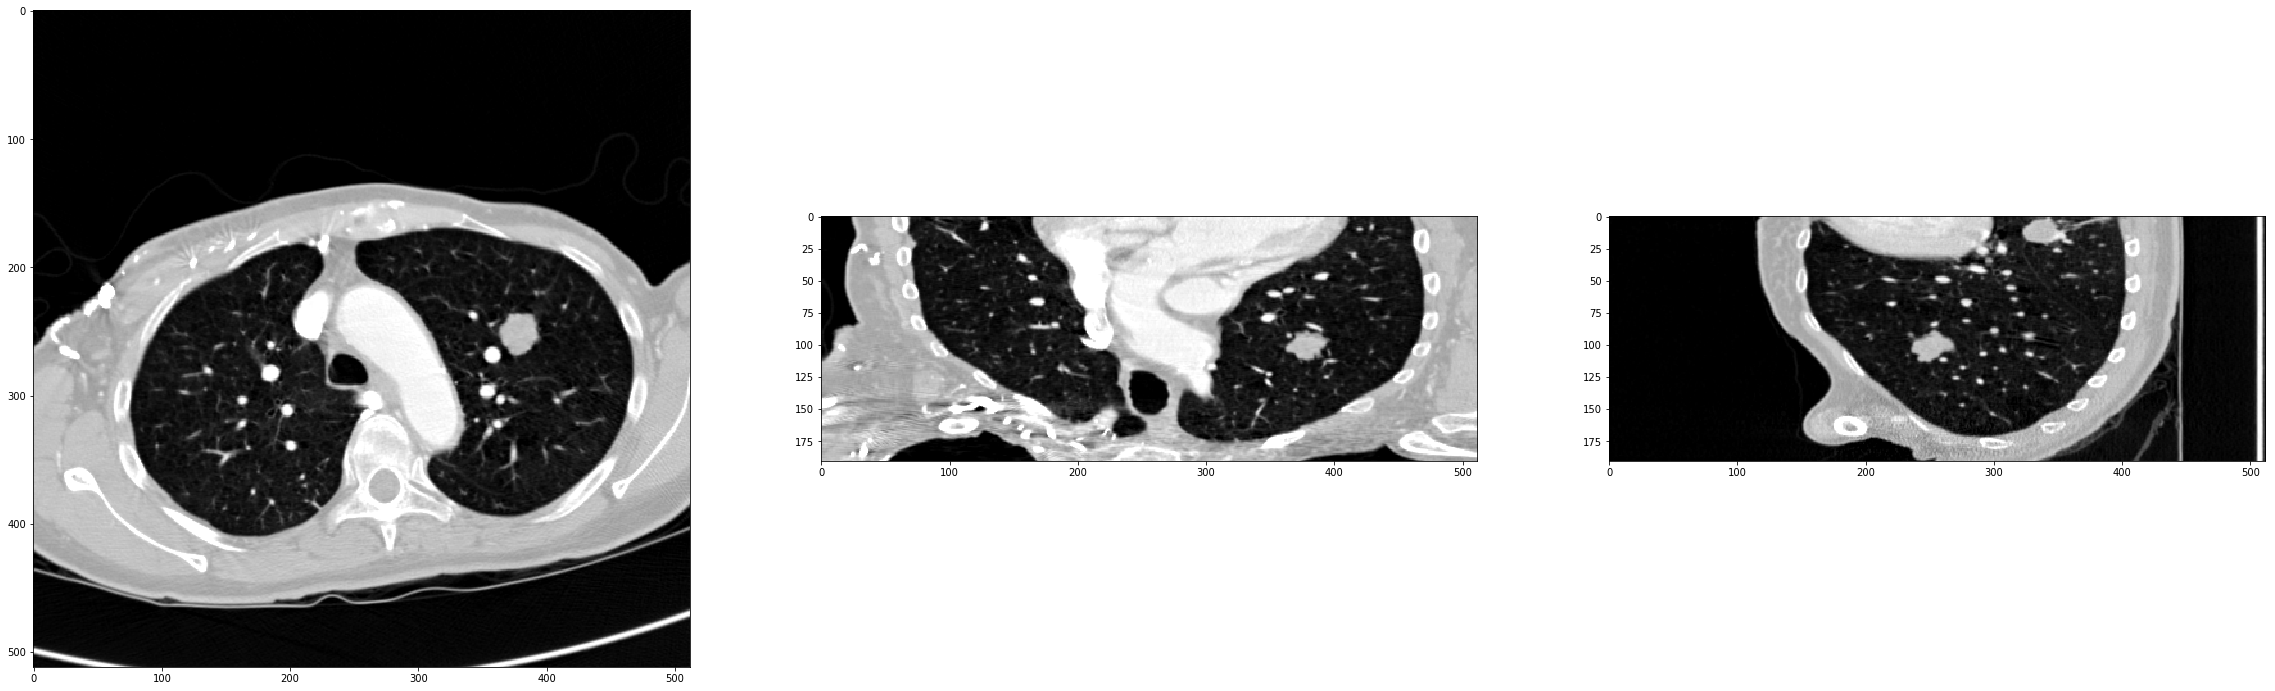

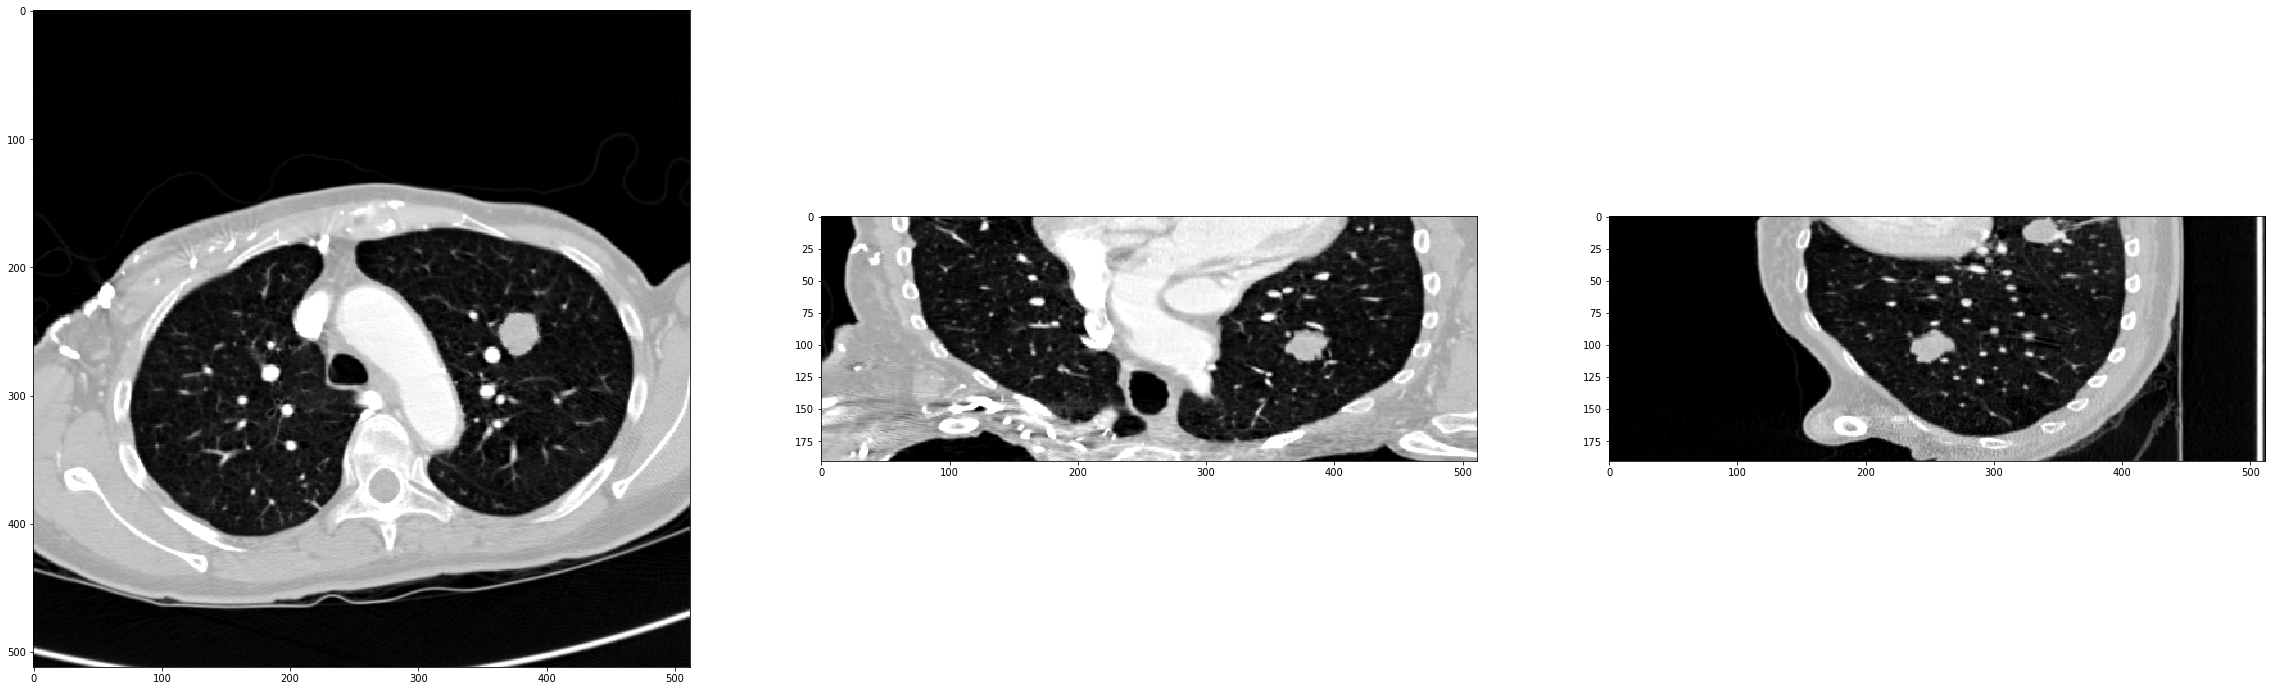

In [3]:
import pandas as pd
from glob import glob
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
LUNA_DIR = '/mnt/data/datasets/LUNA16/'

def find_mhd_file(patient_id):
    for subject_no in range(0, 10):
    # for subject_no in range(0, 1):
        src_dir = LUNA_DIR + "subset" + str(subject_no) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

annotation_csv_path = '/mnt/data/datasets/LUNA16/CSVFILES/annotations.csv'

annotations = pd.read_csv(annotation_csv_path)

row = annotations.iloc[5]
print(row)
print(row['seriesuid'])
mhd_path = find_mhd_file(row['seriesuid'])
print(mhd_path)
itk_img = sitk.ReadImage(mhd_path)
spacing = np.array(list(reversed(itk_img.GetSpacing())))
direction = np.array(itk_img.GetDirection())
origin = np.array(list(reversed(itk_img.GetOrigin())))
flip_x = flip_y = False
if round(direction[0]) == -1:
    origin[2] *= -1
    flip_x = True
    direction[0] = 1

if round(direction[4]) == -1:
    origin[1] *= -1
    flip_y = True
    direction[4] = 1
img_array = sitk.GetArrayFromImage(itk_img).astype(np.float32)
img_array = (255 * (np.clip(img_array, -1000, 400) + 1000) / 1400).astype(np.uint8)
print('img_array', img_array.shape)
z = row['coordZ']
y = row['coordY']
x = row['coordX']
d = row['diameter_mm']
if flip_x:
    x = -x
if flip_y:
    y = -y
z = int(np.rint((z - origin[0]) / spacing[0]))
y = int(np.rint((y - origin[1]) / spacing[1]))
x = int(np.rint((x - origin[2]) / spacing[2]))

r = d / 2
slice_r = 100 # int(np.rint(r / spacing[0])) + 4
r = int(np.rint(r / spacing[2]))

# slice_r = r + 6

print('r', r)
img_array = img_array[z - slice_r : z + slice_r, :, :]

print('y, x', y, x)

plt.figure(figsize=(40,120))
plt.subplot(131)
plt.imshow(img_array[slice_r, :, :], cmap='gray')# zyx
img_array = img_array.transpose([1, 0, 2]) # yzx
plt.subplot(132)
plt.imshow(img_array[y, :, :], cmap='gray')
img_array = img_array.transpose([2, 1, 0]) # xzy
plt.subplot(133)
plt.imshow(img_array[x, :, :], cmap='gray')
img_array = img_array.transpose([1, 2, 0]) # zyx
# for idx in range(slice_r * 2):
#     cv2.imwrite('/mnt/data4/lty/3D_forward_transform/ori_%d.png' % idx, img_array[idx])

img_array = forward_transform_multi_point_3D(img_array, (slice_r,y,x), r, point_num = 26, st = 20)
# for idx in range(slice_r * 2):
#     cv2.imwrite('/mnt/data4/lty/3D_forward_transform/trans_%d.png' % idx, img_array[idx])
plt.figure(figsize=(40,120))
plt.subplot(131)
plt.imshow(img_array[slice_r, :, :], cmap='gray')# zyx
img_array = img_array.transpose([1, 0, 2]) # yzx
plt.subplot(132)
plt.imshow(img_array[y, :, :], cmap='gray')
img_array = img_array.transpose([2, 1, 0]) # xzy
plt.subplot(133)
plt.imshow(img_array[x, :, :], cmap='gray')